<a href="https://colab.research.google.com/github/hungryengineer/ML/blob/master/stock-price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

# Example corpus of sentences
texts = [
    "I love machine learning",
    "I love deep learning",
    "machine learning is fun",
    "deep learning is powerful",
    "I enjoy learning new things",
    "learning new skills is valuable"
]

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Add 1 for padding

# Prepare sequences for next word prediction
sequences = []
for line in texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        seq = token_list[:i+1]
        sequences.append(seq)

# Pad sequences and separate inputs and labels
max_len = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
X, y = sequences[:,:-1], sequences[:,-1]

# One-hot encode the labels
y = np.array(y)

# Build the RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=10, input_length=max_len-1),
    SimpleRNN(50),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=300, verbose=0)

# Function to predict next word given a seed text
def predict_next_word(seed_text):
    token_seq = tokenizer.texts_to_sequences([seed_text])[0]
    token_seq_padded = pad_sequences([token_seq], maxlen=max_len-1, padding='pre')
    predicted_probs = model.predict(token_seq_padded, verbose=0)[0]
    predicted_word_id = np.argmax(predicted_probs)
    for word, idx in word_index.items():
        if idx == predicted_word_id:
            return word
    return ""

# Example predictions
seed_sentences = ["I love", "machine learning", "learning new", "deep"]
predictions = {seed: predict_next_word(seed) for seed in seed_sentences}
predictions


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'GRU' is not defined

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.3869 - val_loss: 0.5119
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2532 - val_loss: 0.2711
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1105 - val_loss: 0.0092
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0367 - val_loss: 0.0276
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0272 - val_loss: 0.0348
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0272 - val_loss: 0.0328
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0311 - val_loss: 0.0077
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0192 - val_loss: 0.0092
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0154 - val_loss: 0.0093
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0173 - val_loss: 0.0090
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0180 - val_loss: 0.0088
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0140 - val_loss: 0.0087
Epoch 13/50

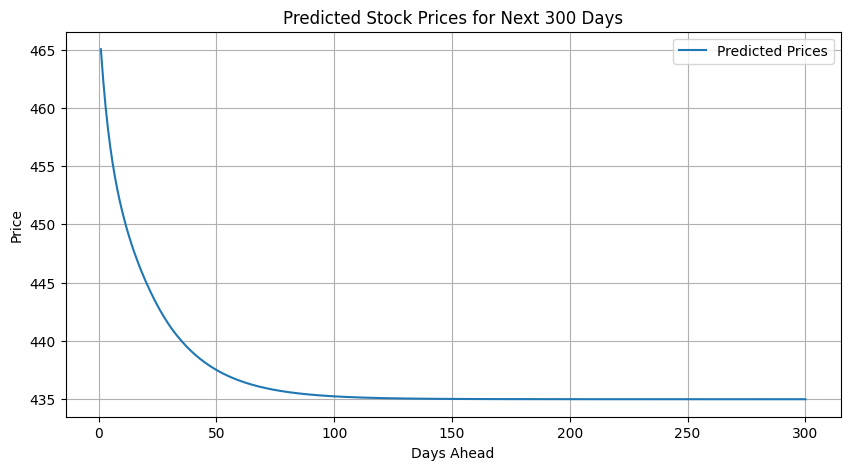

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Step 1: Load Vedanta Limited Data from NSE
ticker = 'VEDL.NS'
data = yf.download(ticker, start="2024-01-01", end="2025-01-01")

# Step 2: Preprocess the Data
closing_prices = data[['Close']].dropna()
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(closing_prices)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_prices, SEQ_LENGTH)
X = X.reshape(X.shape[0], SEQ_LENGTH, 1)  # Reshape for LSTM input

# Step 3: Train the Model and Forecast Prices
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, 1)))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Forecast Next 30 Days
predictions = []
last_sequence = X[-1]

for _ in range(300):
    next_price = model.predict(last_sequence.reshape(1, SEQ_LENGTH, 1), verbose=0)
    next_price_value = next_price[0, 0]  # Extract scalar value
    predictions.append(next_price_value)
    last_sequence = np.append(last_sequence[1:], [[next_price_value]], axis=0)  # Update sequence correctly

predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Step 4: Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(range(1, 301), predicted_prices, label="Predicted Prices")
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.title("Predicted Stock Prices for Next 300 Days")
plt.legend()
plt.grid(True)
plt.show()
